In [1]:
!mkdir result
!mkdir images
!mkdir images/misclassified

In [2]:
import os
import numpy as np
import threading as th
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
import sklearn.metrics as metric
from keras import models, layers
from keras.utils import image_dataset_from_directory as IDFD
from sklearn.metrics import ConfusionMatrixDisplay as CMD, classification_report

from keras.applications import (ConvNeXtBase)

2024-03-01 18:34:52.156594: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-01 18:34:52.156703: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-01 18:34:52.280839: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# test for GPU use in tensorflow
physical_gpus = tf.config.list_physical_devices('GPU')
print(physical_gpus)

# define variables and constants
IMAGE_SIZE = (176, 208)
BATCH_SIZE = 32
EPOCHS = 30

BASE_DIR = './'
IMAGE_DIR = BASE_DIR + 'images/'
MODEL_DIR = BASE_DIR + 'models/'
RESULTS_DIR = BASE_DIR + 'result/'
DATASET_DIR = "/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/"
USE_CPU = False

if USE_CPU:
    tf.config.set_visible_devices([], 'GPU')

print("Tensorflow version", tf.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Tensorflow version 2.15.0


In [4]:
class_names = [filename for filename in os.listdir(DATASET_DIR+'train')]
class_names

['ModerateDemented', 'NonDemented', 'VeryMildDemented', 'MildDemented']

In [5]:
def load(directory, image_size, batch_size, verbose=False):
    class_names = ["Mild_Demented", "Moderate_Demented", "Non_Demented", "Very_Mild_Demented"]
    train_ds = IDFD(directory+"train",
                    seed=7891,
                    validation_split=0.13,
                    subset="training",
                    labels="inferred",
                    label_mode="categorical",
                    interpolation="bilinear",
                    image_size=image_size,
                    batch_size=batch_size,
                    color_mode='rgb')

    val_ds = IDFD(directory+"train",
                   seed=7891,
                   validation_split=0.13,
                   subset="validation",
                   labels="inferred",
                   label_mode="categorical",
                   interpolation="bilinear",
                   image_size=image_size,
                   batch_size=batch_size,
                   color_mode='rgb')

    test_ds = IDFD(directory+"test",
                  seed=7891,
                  labels="inferred",
                  label_mode="categorical",
                  interpolation="bilinear",
                  image_size=image_size,
                  batch_size=batch_size,
                  color_mode='rgb',
                  shuffle=False)

    if verbose:
        train = np.concatenate([np.argmax(l,axis=1) for x,l in train_ds], axis=0)
        val = np.concatenate([np.argmax(l,axis=1) for x,l in val_ds], axis=0)
        test = np.concatenate([np.argmax(l,axis=1) for x,l in test_ds], axis=0)

        print()
        print("Summary:")
        print("--------------------------------")
        print()
        print("Dataset Classes: ", class_names)
        print()
        print("Dataset split:")
        print("--------------------------------")
        print("Using ", len(train), " files for training")
        print("Using ", len(val), " files for validation")
        print("Using ", len(test), " files for testing")
        print()
        print("Images per label in each set:")
        print("--------------------------------")

        print("Training: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(train==i), c)

        print("Validation: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(val==i), c)

        print("Test: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(test==i), c)

        # show sample images
        plt.figure(figsize=(10, 10))
        for images, labels in train_ds.take(1):
            for i in range(9):
                ax = plt.subplot(3, 3, i + 1)
                plt.imshow(images[i].numpy().astype("uint8"))
                plt.title(class_names[np.argmax(labels[i])])
                plt.axis("off")

    return train_ds, val_ds, test_ds, class_names

In [6]:
# plot loss and accuracy graphics

def draw_loss_acc_graphics(outfile, history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc)+1)

    plt.figure()
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'c', label='Validation acc')
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.savefig(outfile + '_accuracy_graph.pdf')
    plt.close()

    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'c', label='Validation loss')
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.savefig(outfile + '_loss_graph.pdf')
    plt.close()

# evaluate model with test set

def process_tests(model, test_ds):
    y_true = np.array([], dtype=np.int32)
    y_pred = np.array([], dtype=np.int32)
    images = []

    for image_batch, labels in test_ds:
        y_true = np.concatenate([y_true, np.argmax(labels.numpy(), axis=-1)])
        y_pred = np.concatenate([y_pred, np.argmax(model.predict(image_batch,verbose=0), axis=-1)])
        for img in image_batch:
            images.append(img)

    size_test = sum([len(l) for _,l in test_ds])
    images = np.reshape(images, (size_test,176,208,3))

    return y_true, y_pred, images

def draw_confusion_matrix(outfile, model, test_ds, class_names):

    # plot confusion matrix
    y_true, y_pred, images = process_tests(model, test_ds)
    plt.figure(figsize=(5, 5))
    cmap = plt.cm.Blues #'viridis'

    # save confusion matrix with classification percentage
    cm = CMD.from_predictions(y_true, y_pred, cmap=cmap, labels=range(len(class_names)),
                              display_labels=class_names, normalize="pred")
    #plt.tight_layout()
    ax = plt.gca()
    plt.setp(ax.yaxis.get_majorticklabels(), rotation=90, ha="center", rotation_mode="anchor")
    plt.savefig(outfile + '_cm.pdf')

    # save confusion matrix with number of samples
    cm = CMD.from_predictions(y_true, y_pred, cmap=cmap,
                              labels=range(len(class_names)),display_labels=class_names)
    plt.savefig(outfile + '_cm2.pdf')
    plt.close()

    # calculate accuracy, precision, recall and F1-score
    accuracy = metric.accuracy_score(y_true, y_pred)
    precision = metric.precision_score(y_true, y_pred, average="macro", zero_division=1)
    recall = metric.recall_score(y_true, y_pred, average="macro")
    f1 = metric.f1_score(y_true, y_pred, average="macro", zero_division=1)
    print('Accuracy | Precision | Recall | F1 score')
    print(accuracy, precision, recall, f1)
    print(metric.precision_recall_fscore_support(y_true, y_pred, average="macro"))

    report = classification_report(
        y_true, y_pred, labels=range(len(class_names)),
        target_names=class_names
    )
    print(report)

    return precision, recall, f1, report

In [7]:
def save_misclassified_images(outfile, model, test_ds, class_names, n_images=3):

    # save incorrectly classified test images
    y_true, y_pred, images = process_tests(model, test_ds)

    a = np.array(y_true) == np.array(y_pred)
    plt.figure()
    ax=plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    j=0
    for i in range(len(a)):
        if not a[i] and j<n_images:
            j=j+1
            plt.imshow(np.array(images[i]).astype("uint8"))
            plt.title(class_names[y_true[i]] + " - " + class_names[y_pred[i]])
            plt.savefig(outfile + '_misclassified_' + str(j) + '.pdf')
    plt.close()

def save_results(filename, model, train_ds, val_ds,
                 test_ds, class_names, history):
    # loss-accuracy graphics
    draw_loss_acc_graphics(IMAGE_DIR+filename, history)

    # confusion matrix
    precision, recall, f1, report = draw_confusion_matrix(IMAGE_DIR+filename, model, test_ds, class_names)

    # misclassified images
    save_misclassified_images(IMAGE_DIR+'misclassified/'+filename, model, test_ds, class_names)

    # save results to file
    train_loss, train_acc = model.evaluate(train_ds)
    val_loss, val_acc     = model.evaluate(val_ds)
    test_loss, test_acc   = model.evaluate(test_ds)

    with open(RESULTS_DIR+filename+'.txt', 'w') as f:
        f.write("Training loss/accuracy: " + str(train_loss) + ', ' + str(train_acc) + '\n')
        f.write("Validate loss/accuracy: " + str(val_loss) + ', ' + str(val_acc) + '\n')
        f.write("Testing  loss/accuracy: " + str(test_loss) + ', ' + str(test_acc) + '\n')
        f.write("Precision: " + str(precision) + '\n')
        f.write("Recall: " + str(recall) + '\n')
        f.write("F1: " + str(f1) + '\n')
        f.write(report + '\n')


In [8]:
# this module creates objects of the different models

def build_cnn_model(model, num_classes,
                    transfer_learning, batch_size):
    weights = None
    trainable = True
    include_top = True
    
    if transfer_learning:
        weights = "imagenet"
        trainable = False
        include_top = False


    model.add(ConvNeXtBase(weights=weights, include_top=include_top,
                                 input_shape=(176,208,3),classes=num_classes))


    model.layers[-1].trainable = trainable

    return model


def create_model(num_classes, data_augmentation, transfer_learning, batch_size=32):
    # base model
    model = models.Sequential()
    model.add(layers.Input(shape=(176,208,3)))

    # data augmentation
    if data_augmentation:
        model.add(layers.RandomFlip("horizontal"))
        model.add(layers.RandomRotation(0.1, fill_mode='constant',fill_value=-1.0))
        model.add(layers.RandomZoom((-0.2,0.2), fill_mode='constant',fill_value=-1.0))

    model = build_cnn_model(model, num_classes,
                            transfer_learning, batch_size)

    # MLP on top
    if transfer_learning:
        model.add(layers.Flatten())
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(loss="categorical_crossentropy",
                  optimizer="adam", metrics=["accuracy"])

    return model

In [9]:
def run_experiments(train_ds, val_ds, test_ds, class_names,
                    epochs, s="", data_augmentation=False, transfer_learning=False):
    
    model = create_model(len(class_names), data_augmentation, transfer_learning, BATCH_SIZE)

    model.summary()

    history = model.fit(train_ds,
                        epochs=epochs,
                        validation_data=val_ds,
                        verbose=1)

    model.save("ConvNeXtBase"+s+".keras")
    

    # save model to disk
    filename = "ConvNeXtBase" + '_' + s

    # save results and graphics to disk
    save_results(filename, model, train_ds,
                 val_ds, test_ds, class_names, history)
        

def experiments_with_dataset(train_ds, val_ds, test_ds, class_names):

    print("Number of classes", len(class_names))

    # training from scratch
    print('  ## training from scratch')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS, 
                    s="_scratch", data_augmentation=False, transfer_learning=False)

    # using data augmentation
    print('  ## training with data augmentation')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS,
                    s="_da", data_augmentation=True, transfer_learning=False)

    # using transfer learning
    print('  ## training with transfer learning')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS,
                    s="_tl", data_augmentation=False, transfer_learning=True)
            
    # using transfer learning and data augmentation
    print('  ## training with transfer learning and data augmentation')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS, 
                    s="_datl", data_augmentation=True, transfer_learning=True)



Processing Alzihmers Dataset:
--------------------------------
Found 5121 files belonging to 4 classes.
Using 4456 files for training.
Found 5121 files belonging to 4 classes.
Using 665 files for validation.
Found 1279 files belonging to 4 classes.
Number of classes 4
  ## training from scratch


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ convnext_base (Functional)      │ (None, 4)              │    87,570,564 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,570,564 (334.06 MB)

 Trainable params: 87,570,564 (334.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30


I0000 00:00:1709318200.735718      80 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1709318200.843034      80 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709318200.843614      80 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709318200.844118      80 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709318200.846916      80 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709318200.847436      80 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709318200.847923      80 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709318200.848388      80 graph_launch.cc:671] Fallback to op-by-op mode because m

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 774ms/step - accuracy: 0.4643 - loss: 2.8285

W0000 00:00:1709318308.720557      80 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709318308.721233      80 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709318308.721721      80 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709318308.724094      80 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709318308.724526      80 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709318308.724959      80 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709318308.725372      80 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709318308.725807      80 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


140/140 ━━━━━━━━━━━━━━━━━━━━ 213s 884ms/step - accuracy: 0.4645 - loss: 2.8192 - val_accuracy: 0.5308 - val_loss: 0.9170
Epoch 2/30


W0000 00:00:1709318324.083837      80 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709318324.084147      80 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709318324.084679      80 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


140/140 ━━━━━━━━━━━━━━━━━━━━ 73s 519ms/step - accuracy: 0.5275 - loss: 0.9258 - val_accuracy: 0.5744 - val_loss: 0.8736
Epoch 3/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 73s 519ms/step - accuracy: 0.5392 - loss: 0.8960 - val_accuracy: 0.5850 - val_loss: 0.8767
Epoch 4/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 73s 519ms/step - accuracy: 0.5605 - loss: 0.8665 - val_accuracy: 0.5835 - val_loss: 0.8424
Epoch 5/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 73s 519ms/step - accuracy: 0.5857 - loss: 0.8413 - val_accuracy: 0.6180 - val_loss: 0.7792
Epoch 6/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 73s 519ms/step - accuracy: 0.6675 - loss: 0.7010 - val_accuracy: 0.7368 - val_loss: 0.5819
Epoch 7/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 82s 518ms/step - accuracy: 0.7824 - loss: 0.5155 - val_accuracy: 0.8331 - val_loss: 0.5562
Epoch 8/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 73s 518ms/step - accuracy: 0.8896 - loss: 0.2947 - val_accuracy: 0.8902 - val_loss: 0.3081
Epoch 9/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 73s 518ms/step - accuracy: 0.9515 - loss: 0.1289 - val

W0000 00:00:1709320491.295270      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709320491.295599      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709320491.296122      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709320491.298400      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709320491.298845      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709320491.299284      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709320491.299733      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709320491.300136      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Accuracy | Precision | Recall | F1 score
0.602814698983581 0.4487846960836861 0.3916484811452514 0.4023820611851135
(0.4487846960836861, 0.3916484811452514, 0.4023820611851135, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.62      0.27      0.37       179
 Moderate_Demented       0.00      0.00      0.00        12
      Non_Demented       0.65      0.74      0.69       640
Very_Mild_Demented       0.53      0.56      0.54       448

          accuracy                           0.60      1279
         macro avg       0.45      0.39      0.40      1279
      weighted avg       0.60      0.60      0.59      1279

140/140 ━━━━━━━━━━━━━━━━━━━━ 25s 176ms/step - accuracy: 1.0000 - loss: 4.1482e-06


W0000 00:00:1709320546.071101      82 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709320546.071449      82 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709320546.071911      82 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709320546.074151      82 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709320546.074517      82 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709320546.074943      82 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709320546.075311      82 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709320546.075690      82 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.9889 - loss: 0.0718
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 252ms/step - accuracy: 0.5838 - loss: 4.7835


W0000 00:00:1709320559.209544      82 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709320559.209992      82 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709320559.210431      82 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709320559.211413      82 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709320559.211811      82 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709320559.212192      82 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709320559.212539      82 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709320559.212928      82 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  ## training with data augmentation


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 176, 208, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 176, 208, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 176, 208, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convnext_base (Functional)      │ (None, 4)              │    87,570,564 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,570,564 (334.06 MB)

 Trainable params: 87,570,564 (334.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 293s 2s/step - accuracy: 0.4359 - loss: 2.6720 - val_accuracy: 0.5383 - val_loss: 0.9696
Epoch 2/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 211s 2s/step - accuracy: 0.4900 - loss: 0.9943 - val_accuracy: 0.4917 - val_loss: 0.9989
Epoch 3/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 211s 2s/step - accuracy: 0.4928 - loss: 0.9602 - val_accuracy: 0.5444 - val_loss: 0.9001
Epoch 4/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 211s 2s/step - accuracy: 0.5259 - loss: 0.9319 - val_accuracy: 0.5263 - val_loss: 0.9325
Epoch 5/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 211s 2s/step - accuracy: 0.5377 - loss: 0.9258 - val_accuracy: 0.5474 - val_loss: 0.8921
Epoch 6/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.5425 - loss: 0.9096 - val_accuracy: 0.5323 - val_loss: 0.8841
Epoch 7/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 211s 2s/step - accuracy: 0.5347 - loss: 0.9218 - val_accuracy: 0.5398 - val_loss: 0.9351
Epoch 8/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 211s 2s/step - accuracy: 0.5227 - loss: 0.9107 - val_accu

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

140/140 ━━━━━━━━━━━━━━━━━━━━ 50s 358ms/step - accuracy: 0.5709 - loss: 0.8331
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 339ms/step - accuracy: 0.5889 - loss: 0.8011
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 399ms/step - accuracy: 0.4260 - loss: 1.3545
  ## training with transfer learning
350926856/350926856 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ convnext_base (Functional)      │ (None, 5, 6, 1024)     │    87,566,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │       122,884 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,689,348 (334.51 MB)

 Trainable params: 122,884 (480.02 KB)

 Non-trainable params: 87,566,464 (334.04 MB)

Epoch 1/30
  1/140 ━━━━━━━━━━━━━━━━━━━━ 57:28 25s/step - accuracy: 0.0938 - loss: 3.5458

W0000 00:00:1709327183.905920      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709327183.906279      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709327183.906751      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709327183.908976      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709327183.909383      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709327183.909771      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709327183.910144      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709327183.910530      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.4894 - loss: 4.2606

W0000 00:00:1709327211.847025      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709327211.847468      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709327211.847973      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709327211.850285      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709327211.850734      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709327211.851155      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709327211.851566      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709327211.852003      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


140/140 ━━━━━━━━━━━━━━━━━━━━ 66s 297ms/step - accuracy: 0.4898 - loss: 4.2497 - val_accuracy: 0.6511 - val_loss: 1.2352
Epoch 2/30


W0000 00:00:1709327225.159464      80 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709327225.159823      80 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709327225.160282      80 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


140/140 ━━━━━━━━━━━━━━━━━━━━ 24s 168ms/step - accuracy: 0.6785 - loss: 1.2584 - val_accuracy: 0.7714 - val_loss: 0.6152
Epoch 3/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 24s 168ms/step - accuracy: 0.7352 - loss: 0.9462 - val_accuracy: 0.7639 - val_loss: 0.6678
Epoch 4/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 24s 168ms/step - accuracy: 0.7694 - loss: 0.8631 - val_accuracy: 0.8150 - val_loss: 0.5471
Epoch 5/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 24s 168ms/step - accuracy: 0.7868 - loss: 0.7561 - val_accuracy: 0.8030 - val_loss: 0.6737
Epoch 6/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 24s 168ms/step - accuracy: 0.7919 - loss: 0.8131 - val_accuracy: 0.6541 - val_loss: 1.6135
Epoch 7/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 24s 168ms/step - accuracy: 0.7792 - loss: 0.9274 - val_accuracy: 0.6827 - val_loss: 1.4268
Epoch 8/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 24s 168ms/step - accuracy: 0.8022 - loss: 0.8621 - val_accuracy: 0.7910 - val_loss: 0.8500
Epoch 9/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 24s 167ms/step - accuracy: 0.8295 - loss: 0.7344 - val

W0000 00:00:1709327987.152759      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709327987.153063      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709327987.153501      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709327987.155726      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709327987.156082      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709327987.156436      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709327987.156800      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709327987.157145      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Accuracy | Precision | Recall | F1 score
0.6309616888193902 0.8155623556151725 0.44471591098031393 0.46239794453793015
(0.8155623556151725, 0.44471591098031393, 0.46239794453793015, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.96      0.13      0.23       179
 Moderate_Demented       1.00      0.17      0.29        12
      Non_Demented       0.79      0.61      0.69       640
Very_Mild_Demented       0.52      0.87      0.65       448

          accuracy                           0.63      1279
         macro avg       0.82      0.44      0.46      1279
      weighted avg       0.72      0.63      0.61      1279

140/140 ━━━━━━━━━━━━━━━━━━━━ 24s 174ms/step - accuracy: 0.9720 - loss: 0.0961


W0000 00:00:1709328041.437771      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709328041.438138      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709328041.438577      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709328041.440831      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709328041.441221      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709328041.441656      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709328041.442072      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709328041.442482      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 0.8837 - loss: 0.5969
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 247ms/step - accuracy: 0.4594 - loss: 7.4968


W0000 00:00:1709328054.327838      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709328054.328215      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709328054.328711      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709328054.329772      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709328054.330196      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709328054.330634      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709328054.331049      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709328054.331451      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  ## training with transfer learning and data augmentation


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_1 (RandomFlip)      │ (None, 176, 208, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_1               │ (None, 176, 208, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_1 (RandomZoom)      │ (None, 176, 208, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convnext_base (Functional)      │ (None, 5, 6, 1024)     │    87,566,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 30720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │       122,884 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,689,348 (334.51 MB)

 Trainable params: 122,884 (480.02 KB)

 Non-trainable params: 87,566,464 (334.04 MB)

Epoch 1/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 84s 463ms/step - accuracy: 0.4656 - loss: 3.8576 - val_accuracy: 0.6180 - val_loss: 1.2039
Epoch 2/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 55s 395ms/step - accuracy: 0.5552 - loss: 2.1146 - val_accuracy: 0.5880 - val_loss: 2.2012
Epoch 3/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 55s 395ms/step - accuracy: 0.5888 - loss: 1.9829 - val_accuracy: 0.6165 - val_loss: 1.7288
Epoch 4/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 55s 395ms/step - accuracy: 0.6174 - loss: 2.0194 - val_accuracy: 0.5639 - val_loss: 3.6967
Epoch 5/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 55s 394ms/step - accuracy: 0.6057 - loss: 2.3769 - val_accuracy: 0.5684 - val_loss: 2.3536
Epoch 6/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 55s 395ms/step - accuracy: 0.5823 - loss: 2.6316 - val_accuracy: 0.6782 - val_loss: 1.3568
Epoch 7/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 82s 394ms/step - accuracy: 0.6434 - loss: 1.9488 - val_accuracy: 0.7233 - val_loss: 1.0413
Epoch 8/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 55s 395ms/step - accuracy: 0.6222 - loss: 2

<Figure size 500x500 with 0 Axes>

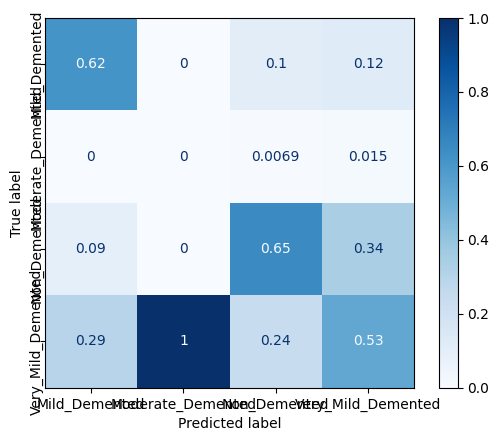

<Figure size 500x500 with 0 Axes>

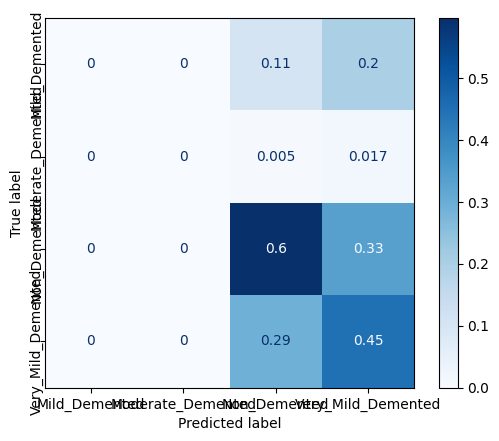

<Figure size 500x500 with 0 Axes>

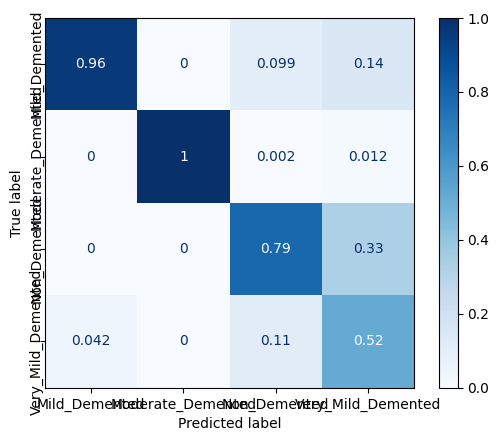

<Figure size 500x500 with 0 Axes>

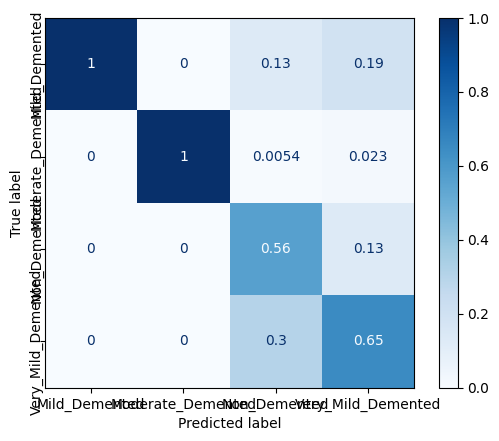

In [10]:
# experiments with Figshare
print('\nProcessing Alzihmers Dataset:')
print('--------------------------------')

train_ds, val_ds, test_ds, class_names = load(DATASET_DIR, IMAGE_SIZE, BATCH_SIZE, False)
experiments_with_dataset(train_ds, val_ds, test_ds, class_names)

In [11]:
!zip -0 -r ConvNeXtBase.zip ./*

  adding: ConvNeXtBase_da.keras (stored 0%)
  adding: ConvNeXtBase_datl.keras (stored 0%)
  adding: ConvNeXtBase_scratch.keras (stored 0%)
  adding: ConvNeXtBase_tl.keras (stored 0%)
  adding: __notebook__.ipynb (stored 0%)
  adding: images/ (stored 0%)
  adding: images/ConvNeXtBase__da_cm2.pdf (stored 0%)
  adding: images/ConvNeXtBase__tl_cm2.pdf (stored 0%)
  adding: images/ConvNeXtBase__scratch_accuracy_graph.pdf (stored 0%)
  adding: images/ConvNeXtBase__tl_accuracy_graph.pdf (stored 0%)
  adding: images/ConvNeXtBase__datl_loss_graph.pdf (stored 0%)
  adding: images/ConvNeXtBase__datl_cm.pdf (stored 0%)
  adding: images/ConvNeXtBase__scratch_cm2.pdf (stored 0%)
  adding: images/ConvNeXtBase__scratch_loss_graph.pdf (stored 0%)
  adding: images/ConvNeXtBase__datl_cm2.pdf (stored 0%)
  adding: images/ConvNeXtBase__scratch_cm.pdf (stored 0%)
  adding: images/misclassified/ (stored 0%)
  adding: images/misclassified/ConvNeXtBase__datl_misclassified_1.pdf (stored 0%)
  adding: images/mis